# Problem Set 2: Nonlinear vs Linearized Least Squares Regression

AI 211 | 2nd Sem AY 2023-2024

Students:  
Joshua Cantor  
Michael Spencer Quinto


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

from numpy import ndarray

warnings.filterwarnings("ignore")

# Nonlinear vs Linearized Least Squares Regression

The Michaelis-Menten equation describes the chemical kinetics of enzyme reactions. According to this equation, if $v_0$ is the initial velocity, $v_{max}$, the maximum velocity, $K_m$ is the Michaelis constant for the reaction and $C$ is the substrate concentration, then

$v_0 = \frac{v_{max}}{1 + \frac{K_m}{C}}.$

In a typical experiment, $v_0$ is measured as $C$ is varied, and then $v_{max}$ and $K_m$ are determined from the resulting data using curve fitting.

| C    | v_0   |
| ---- | ----- |
| 2.5  | 0.024 |
| 5.0  | 0.036 |
| 10.0 | 0.053 |
| 15.0 | 0.060 |
| 20.0 | 0.064 |


In [55]:
# Given data
C = np.array([2.5, 5.0, 10.0, 15.0, 20.0])
v0_observed = np.array([0.024, 0.036, 0.053, 0.060, 0.064])

In [56]:
# Initial guesses for vmax and Km
vmax_initial = 0.1
Km_initial = 0.1

Michaelis-Menten Equation
$$v_0 = \frac{v_{max}}{1 + \frac{K_m}{C}}.$$

Residuals
$$r_i = v_{0i}^{observed} - v_{0i}^{predicted}$$


In [57]:
def michaelis_menten(C: ndarray, vmax: float, Km: float) -> ndarray:
    return vmax / (1 + Km / C)


# def residuals(params: ndarray, C: ndarray, v0_observed: ndarray):
#     vmax, Km = params
#     v0_predicted = michaelis_menten(C, vmax, Km)
#     return v0_observed - v0_predicted

## Gauss-newton Algorithm

- Initial Parameters: Start with initial guesses for $v_{max}$ and $K_m$.

- Predicted Values: Compute the predicted initial velocities using the current parameters:

$$
v_{0,i}^{\text{predicted}} = \frac{v_{\text{max}}}{1 + \frac{K_m}{C_i}}
$$

- Residual Vector: Compute the residuals vector:

$$\mathbf{r} = \mathbf{v}_0^{\text{observed}} - \mathbf{v}_0^{\text{predicted}}$$

- Jacobian Matrix: The Jacobian matrix $J$ contains the partial derivatives of the residuals with respect to each parameter:
  $$J_{ij} = \frac{\partial r_i}{\partial \theta_j}$$
  For our model, the parameters are $\theta = [v_{max}, K*m]$. The partial derivatives are:
  $$\frac{\partial r_i}{\partial v_{max}} = -\frac{\partial v_{0,i}^{\text{predicted}}}{\partial v_{max}} = -\frac{1}{1 + \frac{K_m}{C_i}}$$
  $$\frac{\partial r_i}{\partial K_m} = -\frac{\partial v_{0,i}^{predicted}}{\partial K_m} = -\left(-\frac{v_{\max} \cdot C_i}{(C_i + K_m)^2}\right) = \frac{v_{\max} \cdot C_i}{(C_i + K_m)^2}$$

- Gauss-Newton Step:
  Compute the update step $\Delta \theta$ using the Gauss-Newton formula:

$$\Delta \theta = (J^T J)^{-1} J^T r$$

- Update the parameters
  $$\theta_{new} = \theta_{old} + \Delta \theta$$

- Convergence Check
  Check if the norm of $\Delta \theta$ is less than a specified tolerance. If so, the algorithm has converged.


In [58]:
def gauss_newton(
    C: ndarray,
    v0_observed: ndarray,
    vmax_initial: float,
    Km_initial: float,
    max_iter=100,
    tol=1e-6,
) -> ndarray:
    params = np.array([vmax_initial, Km_initial])

    for _ in range(max_iter):
        vmax, Km = params
        vmax: float
        Km: float

        # Residuals
        v0_predicted = michaelis_menten(C, vmax, Km)
        residuals_vector = v0_observed - v0_predicted

        # Jacobian matrix
        J = np.zeros((len(C), 2))
        J[:, 0] = 1 / (1 + Km / C)  # Partial derivative w.r.t. vmax
        J[:, 1] = -vmax * C / (C + Km) ** 2  # Partial derivative w.r.t. Km

        # Gauss-Newton step
        delta = np.linalg.inv(J.T @ J) @ J.T @ residuals_vector
        params += delta

        # Check for convergence
        if np.linalg.norm(delta) < tol:
            break

    return params

# A: Nonlinear Least Squares using Gauss-Newton

Given the above data, determine $v_{max}$ and $K_m$ using nonlinear least squares (Gauss-Newton)


In [59]:
vmax_final_nls, Km_final_nls = gauss_newton(C, v0_observed, vmax_initial, Km_initial)

print(f"Estimated vmax: {vmax_final_nls}")
print(f"Estimated Km: {Km_final_nls}")

Estimated vmax: 0.08585734500236675
Estimated Km: 6.56189356816215


In [60]:
def plot_curve_fit(C: ndarray, v0_observed: ndarray, vmax: float, Km: float):
    xx = np.linspace(0, 20, 100)
    preds = michaelis_menten(xx, vmax, Km)
    plt.plot(xx, preds)
    plt.scatter(C, v0_observed)
    plt.show()

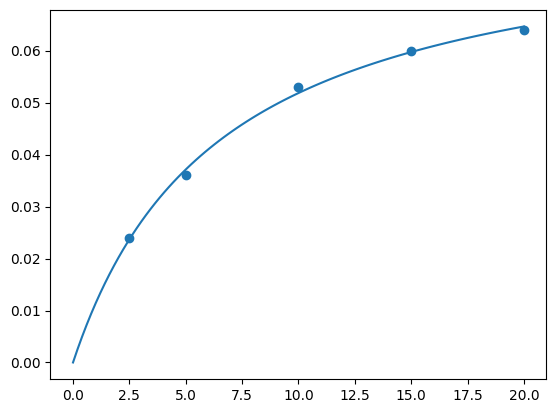

In [61]:
plot_curve_fit(C=C, v0_observed=v0_observed, vmax=vmax_final_nls, Km=Km_final_nls)

# B: Linear Least Squares

Alternatively, nonlinear curve-fitting is avoided by rewriting the equation in linear form:

$$
\text{Lineweaver:} \quad \frac{1}{v_0} = \frac{1}{v_{\max}} + \frac{K_m}{v_{\max}} \frac{1}{C}
$$

$$
\text{Dixon:} \quad \frac{C}{v_0} = \frac{K_m}{v_{\max}} + \frac{1}{v_{\max}} C
$$

$$
\text{Eadie:} \quad v_0 = v_{\max} - K_m \frac{v_0}{C}
$$

Using the same data, determine $v_{\max}$ and $K_m$ using linear least squares from each of these forms.


## Lineweaver-burk


In [62]:
# Given data
C = np.array([2.5, 5.0, 10.0, 15.0, 20.0])
v0_observed = np.array([0.024, 0.036, 0.053, 0.060, 0.064])

# Lineweaver-Burk transformation
x_lb = 1 / C
y_lb = 1 / v0_observed

# Perform linear regression (y = a + bx) using normal equations
X_lb = np.vstack([x_lb, np.ones(len(x_lb))]).T
# Calculate coefficients (beta) using normal equations
beta_lb = np.linalg.inv(X_lb.T @ X_lb) @ X_lb.T @ y_lb
m_lb, c_lb = beta_lb

# Estimate parameters
vmax_lb = 1 / c_lb
Km_lb = m_lb * vmax_lb

print(f"Lineweaver-Burk estimated vmax: {vmax_lb}")
print(f"Lineweaver-Burk estimated Km: {Km_lb}")

Lineweaver-Burk estimated vmax: 0.08474334166355973
Lineweaver-Burk estimated Km: 6.392313059014173


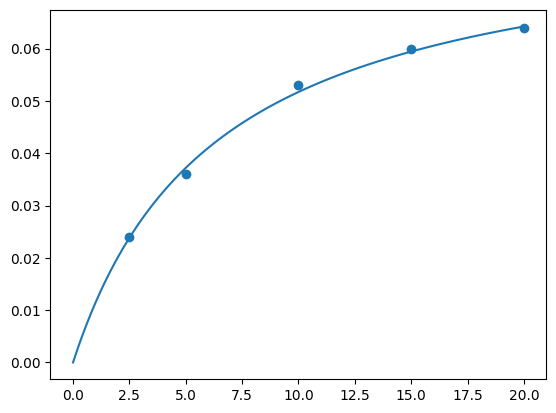

In [63]:
plot_curve_fit(C=C, v0_observed=v0_observed, vmax=vmax_lb, Km=Km_lb)

## Eadie-Hofstee


In [64]:
# Eadie-Hofstee transformation
x_eh = v0_observed / C
y_eh = v0_observed

# Perform linear regression (y = a + bx) using normal equations
X_eh = np.vstack([x_eh, np.ones(len(x_eh))]).T
# Calculate coefficients (beta) using normal equations
beta_eh = np.linalg.inv(X_eh.T @ X_eh) @ X_eh.T @ y_eh
m_eh, c_eh = beta_eh

# Estimate parameters
vmax_eh = c_eh
Km_eh = -m_eh

print(f"Eadie-Hofstee estimated vmax: {vmax_eh}")
print(f"Eadie-Hofstee estimated Km: {Km_eh}")

Eadie-Hofstee estimated vmax: 0.08558065485130677
Eadie-Hofstee estimated Km: 6.515470111144492


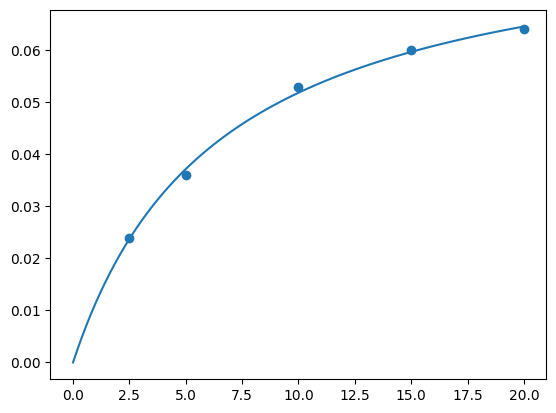

In [65]:
plot_curve_fit(C, v0_observed, vmax_eh, Km_eh)

## Hanes-Woolf Plot


In [66]:
# Hanes-Woolf transformation
x_hw = C
y_hw = C / v0_observed

# Perform linear regression (y = a + bx) using normal equations
X_hw = np.vstack([x_hw, np.ones(len(x_hw))]).T
# Calculate coefficients (beta) using normal equations
beta_hw = np.linalg.inv(X_hw.T @ X_hw) @ X_hw.T @ y_hw
m_hw, c_hw = beta_hw

# Estimate parameters
vmax_hw = 1 / m_hw
Km_hw = c_hw * vmax_hw

print(f"Hanes-Woolf estimated vmax: {vmax_hw}")
print(f"Hanes-Woolf estimated Km: {Km_hw}")

Hanes-Woolf estimated vmax: 0.08533886055581316
Hanes-Woolf estimated Km: 6.46937300569995


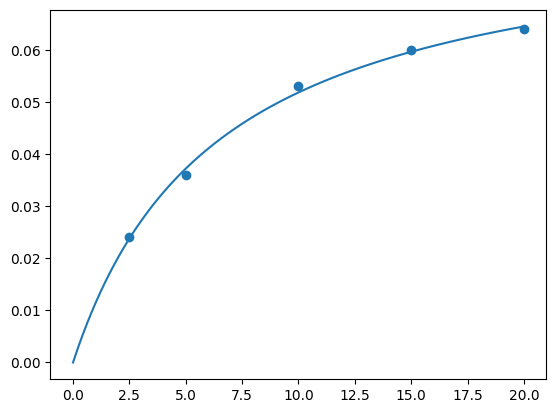

In [67]:
plot_curve_fit(C, v0_observed, vmax_hw, Km_hw)

# C: Comparison

Compare the results in (b) with those obtained using nonlinear least squares in (a). Why do
they differ? Which is/are closest to those determined in (a)? Why?
